### VUONG Christophe & Gudong Sun                                                                    

# <center>Dimensionnement OFDMA</center>
<center> 29 mai 2019 - 11 juin 2019 </center> 
 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Implémentation du modèle 

**1)** D'abord, on simule une cellule circule. $\mathcal{C}=(R, \lambda, p)$. On se place à un instant donné. Voici le code associé ci-dessous.

In [1]:
def cellule(R, lbd, p, Plot=False):
    num_user = np.random.poisson(lbd*np.pi*(R**2)* p)
    pos_users = np.zeros((num_user,2))
    for i in range(num_user):
        pos_users[i,0] = np.sqrt(np.random.rand()) * R
        pos_users[i,1] = np.random.rand() * 2 * np.pi
    if Plot:
        ax = plt.subplot(111, projection = 'polar')
        c = ax.scatter(pos_users[:,1], pos_users[:,0])
        plt.show()
    return pos_users

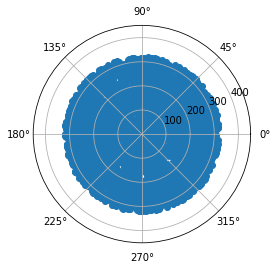

array([[261.80573988,   3.42229658],
       [304.5365854 ,   5.96738589],
       [167.65979314,   2.9589487 ],
       ...,
       [142.5050435 ,   2.8260473 ],
       [183.15810605,   3.24305408],
       [176.64274536,   5.85937155]])

In [4]:
cellule(320, 0.01, 1, Plot=True)

**2)** La probabilité pour un utilisateur d'être actif est $p=0.01$. Représenter le le processus des utilisateurs actifs à chaque instant revient à amincir le processus précédent avec $p$. Donc cela revient à générer un processus de Poisson $\mathcal{P}(p\lambda \pi  R^2)$ avec $\pi  R^2$ l'aire du disque sur lequel se trouve les utilisateurs.

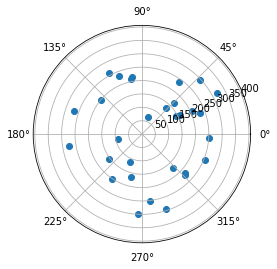

array([[254.57786919,   5.88689675],
       [154.05358926,   3.79261391],
       [198.54202787,   2.44550513],
       [ 90.93770233,   3.36235918],
       [228.76413813,   0.34428404],
       [222.6126049 ,   5.5240212 ],
       [159.64841834,   0.45933862],
       [201.57097063,   4.12871349],
       [319.50482302,   0.50717038],
       [132.00444126,   0.8329147 ],
       [293.02102155,   5.02387547],
       [296.82528411,   0.7447573 ],
       [204.13793069,   0.42909343],
       [171.82702765,   5.46393245],
       [216.05233505,   5.54595909],
       [166.56948221,   4.45761503],
       [216.79937664,   1.73561044],
       [113.41879847,   4.31632157],
       [276.9801428 ,   3.30638364],
       [211.16726774,   1.77035391],
       [240.71048207,   0.95274145],
       [168.13454487,   0.76830705],
       [297.57265861,   4.66856166],
       [252.38051697,   6.22298726],
       [253.2614528 ,   4.83250962],
       [ 67.55494183,   1.2527351 ],
       [234.08554395,   1.95128753],
 

In [5]:
cellule(320, 0.01, 0.01, Plot=True)

Ici, on calcule le nombre moyen d'utilisateurs actifs.

In [46]:
def moyenne(nb_iter, fun, **args):
    mean = 0
    for i in range(nb_iter):
        mean += fun(**args)
    return mean / nb_iter

In [48]:
lbda = 0.01*np.pi*(320**2)*0.01 
args = {'lam':lbda, 'size':None}
moyenne(nb_iter=1000, fun=np.random.poisson, **args)

32.395

In [10]:
# Valeur théorique
lbda = 0.01*np.pi*(320**2)*0.01
lbda

32.169908772759484

On a une très bonne approximation de la valeur théorique (moins d'1% d'erreur). Il faut aussi prendre en compte les effets de bords lorsque l'on compare les résultats de la simulation à la valeur théorique qui est donnée quand on considère tout l'espace.

**3)** On calcule ici la valeur $q_{max}$ en utilisant la formule donnée.

In [6]:
q = math.ceil(162/(180*np.log2(1+0.1)))
q

7

## Probabilité d'outage

**4)** Les resources disponibles $S \in [160, 180]$, on estime $P_S$ avec $K=10^6$ et $\gamma = 2.8$

In [11]:
# 0.1 comme SNRmin, W = 180, C = 162
def func_demand(K, ga, distance):
    demand = math.ceil(162/(180*np.log2(1 + max(0.1,(K/np.power(distance, ga))))))
    return demand

def func_demand_fading(K, ga, distance):
    demand = math.ceil(162/(180*np.log2(1 + max(0.1, (K*np.random.exponential(1)/np.power(distance, ga))))))
    return demand

def prob_outage(start, ends, n, K, ga, mode):
    length = int(ends - start +1)
    P = np.zeros((length,2))
    for sim in range(len(P)):
        outage = 0
        for i in range(n):
            sim_instance = cellule(320, 0.01, 0.01)
            demand = 0
            for j in range(len(sim_instance)):
                distance = sim_instance[j,0]
                # fading ou pas de fading
                if mode == 0:
                    demand += func_demand(K, ga, distance)
                else :
                    demand += func_demand_fading(K, ga, distance)
            if demand > 160 + sim:
                outage += 1
        P[sim, 0] = start + sim
        P[sim, 1] = outage/n
    return P


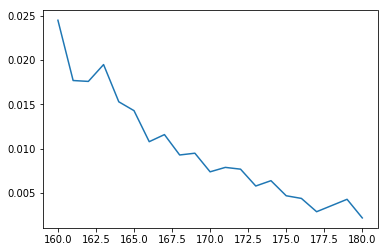

In [64]:
prob_out = prob_outage(160, 180, 10000, 1000000, 2.8, 0)
plt.plot(prob_out[:,0], prob_out[:,1])
plt.show()

**5)** Ici, si on ajoute un utilisateur, on a une variation donnée par $q$, qui donne au maximum $q_{max} = 7$ d'après la 3.

Donc $\beta = 7$, et donc en réinjectant dans la deuxième inégalité de concentration : $\alpha = \beta^2 \pi R^2$

**6)**

In [12]:
def resource_demande(p_max, K, c, w, lbd, p_actif, gam, mode):
    lbd_pi = lbd * np.pi * p_actif
    r = np.zeros(p_max+1)
    resource = 0
    for k in range(1,p_max+1):
        if mode==0:
            r[k] = np.power(K/(np.power(2, c/((k)*w))-1), 1/gam)
        else:
            r[k] = np.power(K*np.random.exponential(1)/(np.power(2, c/((k)*w))-1), 1/gam)
        if r[k]>320:
            r[k]=320
        resource += lbd_pi * (r[k]**2-r[k-1]**2) * k
    return resource


In [69]:
expectec_resource = resource_demande(7, 1000000, 162, 180, 0.01, 0.01, 2.8, 0)
print('le nombre moyen de resource E(F) est', expectec_resource)

le nombre moyen de resource E(F) est 112.07637130779695


In [68]:
args = {'K':1000000, 'ga':2.8,'R':320, 'lbd':0.01, 'p':0.01, 'mode':0}
moyenne(nb_iter=10000, fun=tot_resource, **args)

111.8249

En pratique, on retrouve à peu de chose près la même moyenne. Il faut prendre en compte les effets de bord pour expliquer cette différence malgré le nombre important d'échantillons pris ($10000$).

**7)**

In [13]:
def probability_theoretical(S, expectec_resource, beta, alp_2):
    y = S - expectec_resource
    up_prob = np.exp(-(y/beta+alp_2/(beta**2)) * np.log(1+beta*y/alp_2) + y/beta)
    return up_prob

def plot_theoretical(prob_out, expectec_resource, beta=7, R=320, lbd=0.01,p=0.01):
    S = np.linspace(160,180,21)
    up_prob = np.zeros(len(S))
    for i in range(len(S)):
        up_prob[i] = probability_theoretical(S[i], expectec_resource, beta, p*beta**2*lbd*np.pi*(R**2))
    plt.plot(S, up_prob)
    plt.plot(S, prob_out[:,1])
    plt.show()

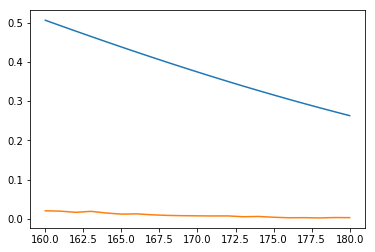

In [20]:
plot_theoretical(prob_out, expectec_resource, beta=7, R=320, lbd=0.01,p=0.01)

**7)** Ici, on voit bien la majoration de la courbe orange (la probabilité d'outage) par rapport à l'exponentielle recentrée pour la comparaison.

**8)**

In [14]:
def cal_expect(expectec_resource, p = 0.01, beta = 7, lbd=0.01, R = 320):
    S = 180
    P=1
    while P>0.01:
        P = probability_theoretical(S, expectec_resource, beta, p*beta**2*lbd*np.pi*(R**2))
        S += 1
    return S

In [22]:
resource_expected = cal_expect(expectec_resource, p = 0.01, beta = 7, lbd=0.01, R = 320)
print('La dimension de', resource_expected)

La dimension de 244


In [62]:
def tot_resource(K, ga, R, lbd, p, mode):
    sim_instance = cellule(R, lbd, p)
    demand = 0
    for j in range(len(sim_instance)):
        distance = sim_instance[j,0]
        if mode == 0:
            demand += func_demand(K, ga, distance)
        else:
            demand += func_demand_fading(K, ga, distance)
    return demand


def prob_outage_known_resource(resource_expected, n, K, ga, R, lbd, p, mode):
    outage = 0
    a = 0
    for i in range(n):
        demand = tot_resource(K, ga, R, lbd, p, mode)
        if demand > resource_expected:
            outage += 1
    P = outage/n
    return P

With the dimension of 244, we have:

In [45]:
outage_244 = prob_outage_known_resource(244, 100000, 1000000, 2.8, 320, 0.01, 0.01, 0)
print('The outage probability with lbd = 0.01:',outage_244)

The outage probability with lbd = 0.01: 0.0


In [46]:
outage_244 = prob_outage_known_resource(244, 100000, 1000000, 2.8, 320, 0.011, 0.01, 0)
print('The outage probability if lbd varies +10%:',outage_244)

The outage probability with lbd varie 10%: 2e-05


In [16]:
outage_244 = prob_outage_known_resource(244, 100000, 1000000, 2.8, 320, 0.009, 0.01, 0)
print('The outage probability if lbd varies -10%:',outage_244)

The outage probability if lbd varies -10%: 0.0


In [47]:
outage_244 = prob_outage_known_resource(244, 100000, 1000000, 2.8, 320, 0.012, 0.01, 0)
print('The outage probability if lbd varies 20%:',outage_244)

The outage probability with lbd varie 20%: 6e-05


In [49]:
outage_244 = prob_outage_known_resource(244, 100000, 1000000, 2.8*(0.98), 320, 0.01, 0.01, 0)
print('The outage probability if gamma varies -2%:',outage_244)

The outage probability if gamma varies -2%: 0.0


In [48]:
outage_244 = prob_outage_known_resource(244, 100000, 1000000, 2.8*(1.02), 320, 0.01, 0.01, 0)
print('The outage probability if gamma varies 2%:',outage_244)

The outage probability with gamma varie 2%: 0.00019


In [49]:
outage_244 = prob_outage_known_resource(244, 100000, 1000000, 2.8*(1.05), 320, 0.01, 0.01, 0)
print('The outage probability if the gamma varies 5%:',outage_244)

The outage probability with gamma varie 5%: 0.00483


**11)** Le dimensionnement S obtenu ici permet de garder le majorant à un valeur de 0.01, même lorsque certains paramètres de la simulation varient légèrement (inférieur à 0.01). Donc le dimensionnement obtenu est bon.

## Introduction du Fading

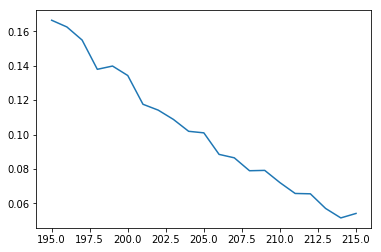

In [65]:
prob_out = prob_outage(195, 215, 10000, 1000000, 2.8, 1)
plt.plot(prob_out[:,0], prob_out[:,1])
plt.show()

On a pour les mêmes dimensionnements des probabilités d'outage 10 fois plus élevées en ordre de grandeur, ce qui semble cohérent avec l'effet du fading. 

On utilise l'expression précédente de l'espérance auquel on applique un facteur multiplicatif :

$$\boxed{\mathbb{E}(F_m) = \mathbb{E}(F)\:\Gamma \left(\frac{2}{\gamma} + 1\right)}$$

In [17]:
expectec_resource = 112.07637130779695 * math.gamma(2/2.8 + 1)
print('le nombre moyen de resource est',expectec_resource)

le nombre moyen de resource est 102.14902063188036


On calcule la moyenne obtenue avec nos simulations :

In [66]:
args = {'K':1000000, 'ga':2.8,'R':320, 'lbd':0.01, 'p':0.01, 'mode':1}
moyenne(nb_iter=10000, fun=tot_resource, **args)

134.4851

Avec plusieurs essais, on se retrouve avec des valeurs au-dessus de $130$, ce qui ne s'approche pas de la moyenne théorique. Les effets de bord sont peut-être plus importants en prenant en compte le fading.

**14)** On calcule le dimensionnement associé S, avec l'espérance trouvée à la question 13.

In [51]:
S = cal_expect(expectec_resource, p = 0.01, beta = 7, lbd=0.01, R = 320)
S

234

**15)**

In [57]:
outage_234 = prob_outage_known_resource(234, 100000, 1000000, 2.8, 320, 0.01, 0.01, 1)
print('The outage probability with lbd = 0.01:',outage_234)

The outage probability with lbd = 0.01: 0.00043


In [58]:
outage_234 = prob_outage_known_resource(234, 100000, 1000000, 2.8, 320, 0.011, 0.01, 1)
print('The outage probability if lbd varies 10%:',outage_234)

The outage probability if lbd varies 10%: 0.00268


In [59]:
outage_234 = prob_outage_known_resource(234, 100000, 1000000, 2.8, 320, 0.012, 0.01, 1)
print('The outage probability if lbd varies 20%:',outage_234)

The outage probability if lbd varies 20%: 0.01084


In [60]:
outage_234 = prob_outage_known_resource(234, 100000, 1000000, 2.8*(1.02), 320, 0.01, 0.01, 1)
print('The outage probability if gamma varies 2%:',outage_234)

The outage probability if gamma varies 2%: 0.00313


In [61]:
outage_234 = prob_outage_known_resource(234, 100000, 1000000, 2.8*(1.05), 320, 0.01, 0.01, 1)
print('The outage probability if the gamma varies 5%:',outage_234)

The outage probability if the gamma varies 5%: 0.02018


**16)** On voit que le dimensionnement n'est pas aussi bon que dans la partie précédente, car lorsque certains paramètres varient avec des proportions raisonnables, le majorant dépasse 0.01, donc la marge que l'on prend avec ce dimensionnement n'est pas aussi bonne que dans le premier cas. Le modèle associé n'est donc pas aussi flexible. Le dimensionnement S n'est donc pas bon dans ce cas.